# Energiedatenauswertung am Beispiel

Im folgenden Teil sollen Daten aus der Energiedatenerfassung ausgewertet werden.
Ein Beispieldatensatz wurde aus der Datenbank in die Datei "db_export_CMX600T_2022-12-01.csv" exportiert.

Lesen wir diese Datei zunächst ein. Anders als im letzten Beispiel sind die Einzelnen Spalten mit Semikolon getrennt.
Daher wird der sep-Parameter hier modifiziert:

In [ ]:
import pandas as pd
data = pd.read_csv("db_export_CMX600T_2022-12-01.csv", sep = ";")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Zeitstempel_ms         6430 non-null   int64  
 1   ID                     6430 non-null   int64  
 2   Zeitstempel            6430 non-null   object 
 3   Zeitstempel_ms.1       6430 non-null   int64  
 4   Zeitstempel_Unix_ms    6430 non-null   int64  
 5   Strom_gesamt           6430 non-null   object 
 6   Spannung_gesamt        6430 non-null   object 
 7   Wirkleistung_gesamt    6430 non-null   object 
 8   Scheinleistung_gesamt  6430 non-null   object 
 9   Blindleistung_gesamt   6430 non-null   object 
 10  Energie_gesamt_kwh     6430 non-null   object 
 11  cosPhi_gesamt          6430 non-null   object 
 12  Phi_gesamt             6430 non-null   object 
 13  sinPhi_gesamt          6430 non-null   object 
 14  Frequenz_gesamt        6430 non-null   object 
 15  Stro

Schauen wir uns die Daten noch einmal an, da hier kaum Zahlenwerte vorhanden sind:

In [4]:
data

,Zeitstempel_ms,ID,Zeitstempel,Zeitstempel_ms.1,Zeitstempel_Unix_ms,Strom_gesamt,Spannung_gesamt,Wirkleistung_gesamt,Scheinleistung_gesamt,Blindleistung_gesamt,...,Spannung_Phase3,Wirkleistung_Phase3,Scheinleistung_Phase3,Blindleistung_Phase3,Energie_Phase3_kwh,cosPhi_Phase3,Phi_Phase3,sinPhi_Phase3,Frequenz_Phase3,Unnamed: 45
0,0,10491582,"2022-11-30 15:51:14,754",1669823475754,1669819875754,0,"397,61558782831105",0,0,0,...,"229,0396",0,0,0,"6,635052",0,0,0,50,NaN
1,99,10491583,"2022-11-30 15:51:14,853",1669823475853,1669819875853,0,"397,6696278135072",0,0,0,...,"229,0576",0,0,0,"6,635052",0,0,0,50,NaN
2,200,10491584,"2022-11-30 15:51:14,954",1669823475954,1669819875954,0,"397,7299031816106",0,0,0,...,"229,06380000000001",0,0,0,"6,635052",0,0,0,50,NaN
3,299,10491585,"2022-11-30 15:51:15,053",1669823475053,1669819875053,0,"397,77020223040006",0,0,0,...,"229,08360000000002",0,0,0,"6,635052",0,0,0,50,NaN
4,400,10491586,"2022-11-30 15:51:15,154",1669823475154,1669819875154,0,"397,7618883865237",0,0,0,...,"229,0688",0,0,0,"6,635052",0,0,0,50,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6425,644774,10498007,"2022-11-30 16:01:59,528",1669824120528,1669820520528,"1,958845540311946","397,94998910422566","495,36","778,2999725040002","581,1409245257288",...,"229,2294","134,28","243,29033139600003","202,8769749152809","6,663468","0,5710000000000001","0,9861156216275601","0,833888357795284",50,NaN
6426,644874,10498008,"2022-11-30 16:01:59,628",1669824120628,1669820520628,"1,9578409508435561","397,9459476523413","488,04","779,775120588","592,6057794817875",...,"229,1926","126,48","242,343671388","206,72025701854895","6,66348","0,5","1,0217154215038937","0,8530045609797797",50,NaN
6427,644974,10498009,"2022-11-30 16:01:59,728",1669824120728,1669820520728,"1,9607854372164233","397,9653466213861","487,08","779,7874672680001","593,9363699461849",...,"229,2244",126,"241,81340404800002","206,39215677268677","6,66348","0,5","1,0227005016156103","0,8535182637423931",50,NaN
6428,645074,10498010,"2022-11-30 16:01:59,828",1669824120828,1669820520828,"1,9639031286700472","397,9431763710492","494,4","781,1417506320001","586,6364260466314",...,"229,2184",126,"241,91709936000004","206,51363868460632","6,663492","0,5","1,0229621603468093","0,8536545751868935",50,NaN


Auch die Zahlen sind hier in einem anderen Format, wir müssen die "," in "." wandeln.

In [22]:
data = pd.read_csv("db_export_CMX600T_2022-12-01.csv", sep = ";", decimal=",")
data

,Zeitstempel_ms,ID,Zeitstempel,Zeitstempel_ms.1,Zeitstempel_Unix_ms,Strom_gesamt,Spannung_gesamt,Wirkleistung_gesamt,Scheinleistung_gesamt,Blindleistung_gesamt,...,Spannung_Phase3,Wirkleistung_Phase3,Scheinleistung_Phase3,Blindleistung_Phase3,Energie_Phase3_kwh,cosPhi_Phase3,Phi_Phase3,sinPhi_Phase3,Frequenz_Phase3,Unnamed: 45
0,0,10491582,"2022-11-30 15:51:14,754",1669823475754,1669819875754,0.000000,397.615588,0.00,0.000000,0.000000,...,229.0396,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
1,99,10491583,"2022-11-30 15:51:14,853",1669823475853,1669819875853,0.000000,397.669628,0.00,0.000000,0.000000,...,229.0576,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
2,200,10491584,"2022-11-30 15:51:14,954",1669823475954,1669819875954,0.000000,397.729903,0.00,0.000000,0.000000,...,229.0638,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
3,299,10491585,"2022-11-30 15:51:15,053",1669823475053,1669819875053,0.000000,397.770202,0.00,0.000000,0.000000,...,229.0836,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
4,400,10491586,"2022-11-30 15:51:15,154",1669823475154,1669819875154,0.000000,397.761888,0.00,0.000000,0.000000,...,229.0688,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6425,644774,10498007,"2022-11-30 16:01:59,528",1669824120528,1669820520528,1.958846,397.949989,495.36,778.299973,581.140925,...,229.2294,134.28,243.290331,202.876975,6.663468,0.571,0.986116,0.833888,50.0,NaN
6426,644874,10498008,"2022-11-30 16:01:59,628",1669824120628,1669820520628,1.957841,397.945948,488.04,779.775121,592.605779,...,229.1926,126.48,242.343671,206.720257,6.663480,0.500,1.021715,0.853005,50.0,NaN
6427,644974,10498009,"2022-11-30 16:01:59,728",1669824120728,1669820520728,1.960785,397.965347,487.08,779.787467,593.936370,...,229.2244,126.00,241.813404,206.392157,6.663480,0.500,1.022701,0.853518,50.0,NaN
6428,645074,10498010,"2022-11-30 16:01:59,828",1669824120828,1669820520828,1.963903,397.943176,494.40,781.141751,586.636426,...,229.2184,126.00,241.917099,206.513639,6.663492,0.500,1.022962,0.853655,50.0,NaN


Wir haben jetzt im Prinzip 2x einen Index. Der Originalindex ist in der Spalte ID eingetragen. Diesen können wir auch als Index für den DataFrame nutzen:

In [23]:
data = data.set_index('ID')
data

,Zeitstempel_ms,Zeitstempel,Zeitstempel_ms.1,Zeitstempel_Unix_ms,Strom_gesamt,Spannung_gesamt,Wirkleistung_gesamt,Scheinleistung_gesamt,Blindleistung_gesamt,Energie_gesamt_kwh,...,Spannung_Phase3,Wirkleistung_Phase3,Scheinleistung_Phase3,Blindleistung_Phase3,Energie_Phase3_kwh,cosPhi_Phase3,Phi_Phase3,sinPhi_Phase3,Frequenz_Phase3,Unnamed: 45
ID,,,,,,,,,,,,,,,,,,,,,
10491582,0,"2022-11-30 15:51:14,754",1669823475754,1669819875754,0.000000,397.615588,0.00,0.000000,0.000000,16.996620,...,229.0396,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
10491583,99,"2022-11-30 15:51:14,853",1669823475853,1669819875853,0.000000,397.669628,0.00,0.000000,0.000000,16.996620,...,229.0576,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
10491584,200,"2022-11-30 15:51:14,954",1669823475954,1669819875954,0.000000,397.729903,0.00,0.000000,0.000000,16.996620,...,229.0638,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
10491585,299,"2022-11-30 15:51:15,053",1669823475053,1669819875053,0.000000,397.770202,0.00,0.000000,0.000000,16.996620,...,229.0836,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
10491586,400,"2022-11-30 15:51:15,154",1669823475154,1669819875154,0.000000,397.761888,0.00,0.000000,0.000000,16.996620,...,229.0688,0.00,0.000000,0.000000,6.635052,0.000,0.000000,0.000000,50.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10498007,644774,"2022-11-30 16:01:59,528",1669824120528,1669820520528,1.958846,397.949989,495.36,778.299973,581.140925,17.094384,...,229.2294,134.28,243.290331,202.876975,6.663468,0.571,0.986116,0.833888,50.0,NaN
10498008,644874,"2022-11-30 16:01:59,628",1669824120628,1669820520628,1.957841,397.945948,488.04,779.775121,592.605779,17.094396,...,229.1926,126.48,242.343671,206.720257,6.663480,0.500,1.021715,0.853005,50.0,NaN
10498009,644974,"2022-11-30 16:01:59,728",1669824120728,1669820520728,1.960785,397.965347,487.08,779.787467,593.936370,17.094408,...,229.2244,126.00,241.813404,206.392157,6.663480,0.500,1.022701,0.853518,50.0,NaN


###  <font color = darkblue> Aufgabe</font>
a) Erzeugen Sie einen neuen Dataframe, der nur den Zeitstempel_ms und die Wirkleistung_gesamt enthält!

In [37]:
df = data[['Zeitstempel_ms','Wirkleistung_gesamt']]


b) Stellen Sie die Wirkleistung über der Zeit als Plot dar!

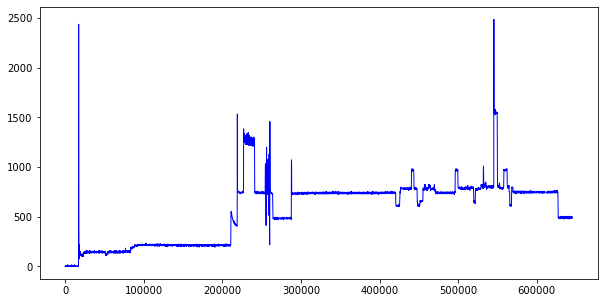

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Plot erzeugen
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.Zeitstempel_ms, df.Wirkleistung_gesamt, linewidth=1.0, color='b')

# Plot anzeigen
plt.show()

c) schauen Sie sich Bereiche an, z.B den ersten Peak.

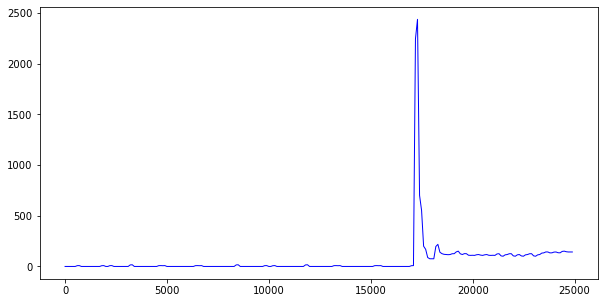

In [43]:
df = df[0:250]
# Plot erzeugen
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.Zeitstempel_ms, df.Wirkleistung_gesamt, linewidth=1.0, color='b')

# Plot anzeigen
plt.show()

### Einschub: Alternative Bibliothek für intreaktive Diagramme

Im Video aus dem Einstiegskurs wurde eine weitere Bibliothek vorgestellt, die eine interaktive Darstellung im Jupyter-Notebook ermöglicht. 
Es ist die altair-Bibliothek, auch diese Bibliothek ist im Python-Package-Index verfügbar:<br/>
https://pypi.org/project/altair/

Aber Achtung: die Bibliothek sorgt bei vielen Visualisierungen mit großen Datensätzen für sehr große Notebooks!

In [ ]:
pip install altair --user

In [57]:
import altair as alt

df = data[['Zeitstempel_ms','Wirkleistung_gesamt']]

alt.data_transformers.disable_max_rows() # Eigentlich sind nur 5000 Zeilen erlaubt

alt.Chart(df).mark_line().encode(
    x='Zeitstempel_ms',
    y='Wirkleistung_gesamt'
).properties(
    width=800,
    height=300
).interactive()

alt.Chart(...)

### Ereignisse auswerten
Offensichtlich passiert in diesem Ausschnitt an einigen Stellen eine Änderung der Betriebszustände. 
Wir versuchen nur automatisiert auszuwerten, zu welchem Zeitpunkt die Ereignisse auftreten.<br/>


Erster Ansatz: Alle Punkte herausfiltern, die einen bestimmten Grenzwert überschreiten.

#### Werte über einem Grenzwert filtern

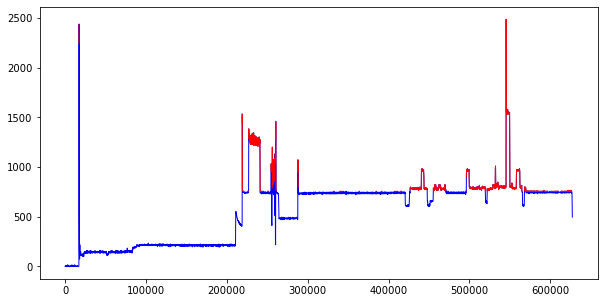

In [169]:
df = data.loc[:,('Zeitstempel_ms','Wirkleistung_gesamt')]
df['Grenzwert'] = df[df.Wirkleistung_gesamt > 750].Wirkleistung_gesamt

number_of_samples = 6250
df = df[0:number_of_samples]

# Plot erzeugen
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.Zeitstempel_ms, df.Wirkleistung_gesamt, linewidth=1.0, color='b')
ax.plot(df.Zeitstempel_ms, df.Grenzwert, linewidth=1.0, color='r')

# Plot anzeigen
plt.show()

###  <font color = darkblue> Aufgabe</font>

Filtern Sie alle Werte, die zwischen 600 und 750 liegen!

In [172]:
df = data.loc[:,('Zeitstempel_ms','Wirkleistung_gesamt')]
df['Grenzwert'] = df[df.Wirkleistung_gesamt >= 600 and df.Wirkleistung_gesamt < 750].Wirkleistung_gesamt

number_of_samples = 6250
df = df[0:number_of_samples]

# Plot erzeugen
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.Zeitstempel_ms, df.Wirkleistung_gesamt, linewidth=1.0, color='b')
ax.plot(df.Zeitstempel_ms, df.Grenzwert, linewidth=1.0, color='r')

# Plot anzeigen
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

#### Gleitender Mittelwert als Filter

Oft ist es eine gute Idee, die Daten zunächst zu glätten. Das kann z.B. mit dem gleitenden Mittelwert passieren.

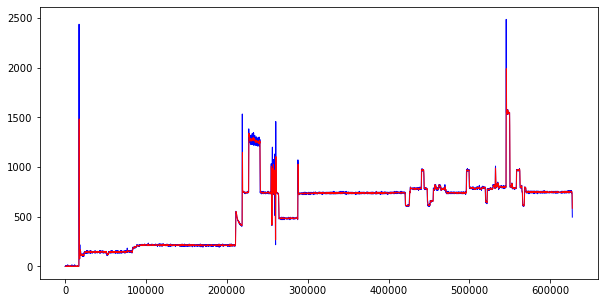

In [164]:
df = data.loc[:,('Zeitstempel_ms','Wirkleistung_gesamt')]
df['Mittelwert'] = df['Wirkleistung_gesamt'].rolling(4).mean()

number_of_samples = 6250
df = df[0:number_of_samples]

# Plot erzeugen
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.Zeitstempel_ms, df.Wirkleistung_gesamt, linewidth=1.0, color='b')
ax.plot(df.Zeitstempel_ms, df.Mittelwert, linewidth=1.0, color='r')

# Plot anzeigen
plt.show()

### Nutzung einfacher maschineller Lernalgorithmen zur Ausreißererkennung

#### Beispiel: Unüberwachte Ausreißererkennung unter Verwendung des lokalen Ausreißerfaktors (LOF).

Die Anomaliebewertung jeder Probe wird als lokaler Ausreißerfaktor bezeichnet. Er misst die lokale Abweichung der Dichte einer bestimmten Probe im Vergleich zu ihren Nachbarn. Er ist insofern lokal, als die Anomaliebewertung davon abhängt, wie isoliert das Objekt im Vergleich zu seiner Umgebung ist. Genauer gesagt ist die Lokalität durch die k-ächsten Nachbarn gegeben, deren Abstand zur Schätzung der lokalen Dichte verwendet wird. Durch den Vergleich der lokalen Dichte einer Probe mit den lokalen Dichten ihrer Nachbarn lassen sich Proben identifizieren, die eine wesentlich geringere Dichte als ihre Nachbarn aufweisen. Diese werden als Ausreißer bezeichnet.

Wir nutzen wieder eine Bibliothek. Diesmal scikit-learn eine Bibliothek für maschinelles Lernen:<br/>
https://pypi.org/project/scikit-learn/


In [165]:
# Bibliothek importieren
from sklearn.neighbors import LocalOutlierFactor

# Wirkleistung umformatieren in einen Wertebereich zwischen -1 und 1
x = np.array(df['Wirkleistung_gesamt']).reshape(-1,1)

# Wir arbeiten mit den n-n*0.1 nächsten Nachbarn
model = LocalOutlierFactor(n_neighbors = int(number_of_samples - number_of_samples * 0.1))


label = model.fit_predict(x)
label

array([1, 1, 1, ..., 1, 1, 1])

Alle Werte, die als Ausreißer identifiziert wurden sind mit -1 gelabelt. Plotten wir diese als Punkte:                                

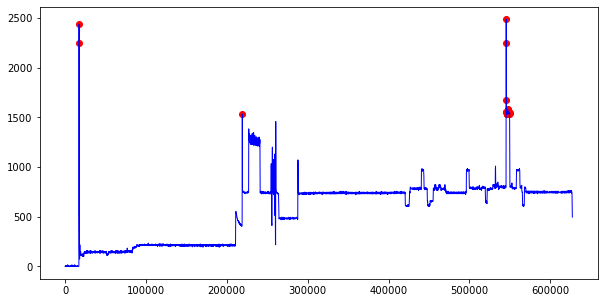

In [166]:
# Erzeuge 2 leere Listen
x = []
y = []

for i in range(len(label)):
    if label[i]!=1:
        x.append(df.iloc[i, 0])
        y.append(df.iloc[i, 1])

# Plot erzeugen
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.Zeitstempel_ms, df.Wirkleistung_gesamt, linewidth = 1.0, color = 'b')
ax.scatter(x, y, color = 'r', marker = 'o')

# Plot anzeigen
plt.show()

###  <font color = darkblue> Aufgabe</font>
Ändern Sie die Außreißererkennung so ab, dass Sie immer in Abschnitten von 250 Samples nach Ausreißern suchen.
Es sollen also 25 Abschnitte untersucht werden.
Nutzen Sie das Code Template unten. Was beobachten Sie?

0


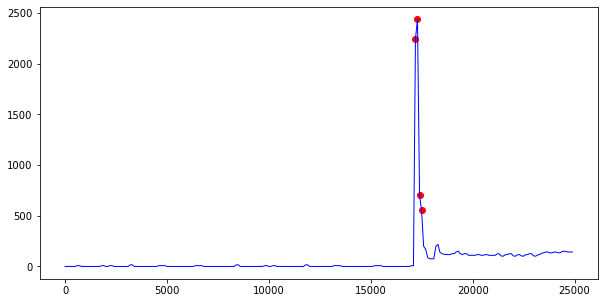

1


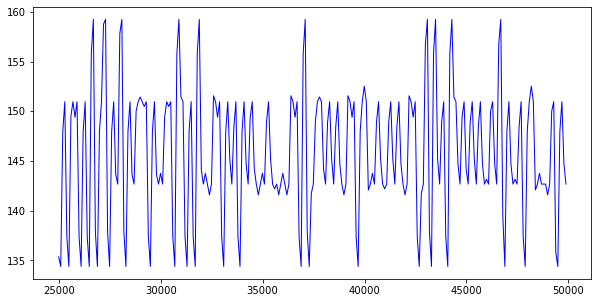

2


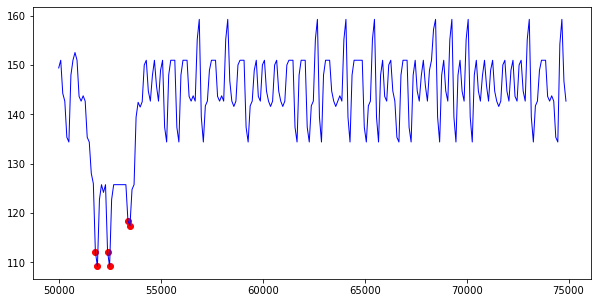

3


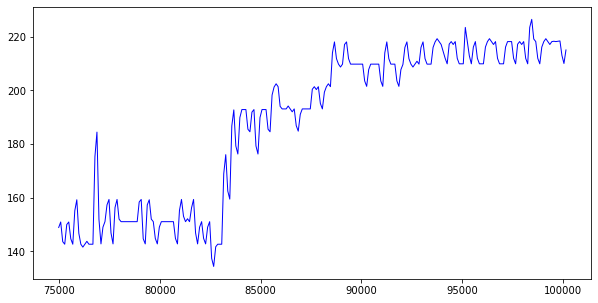

4


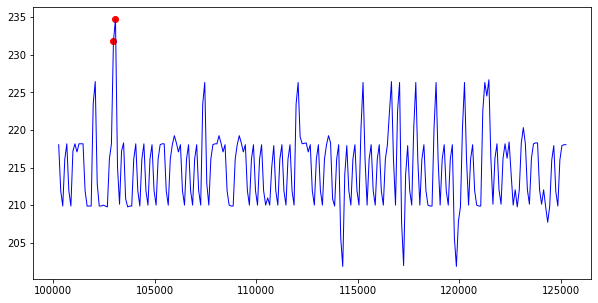

5


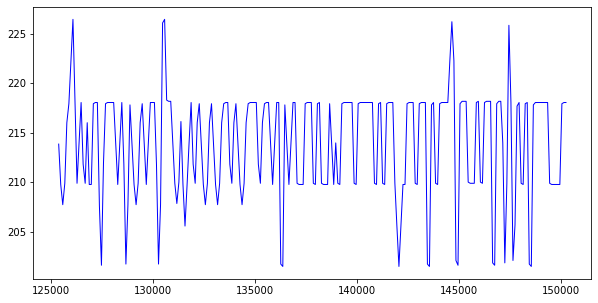

6


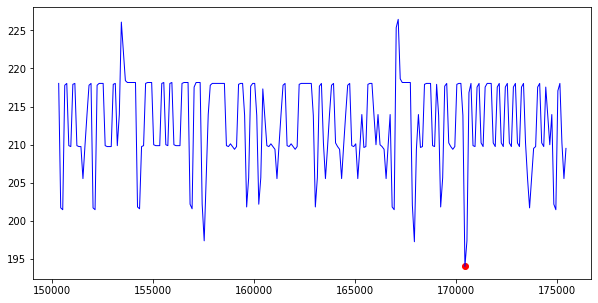

7


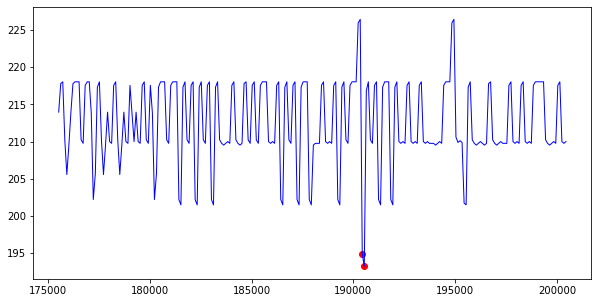

8


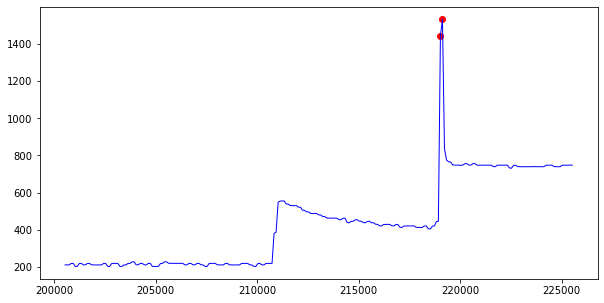

9


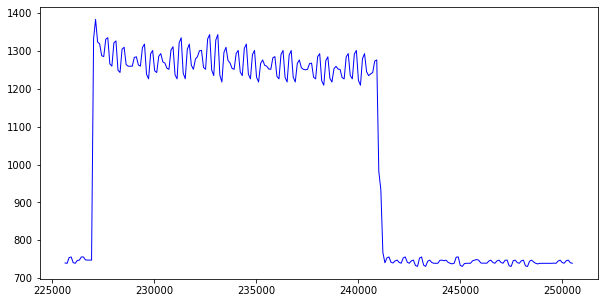

10


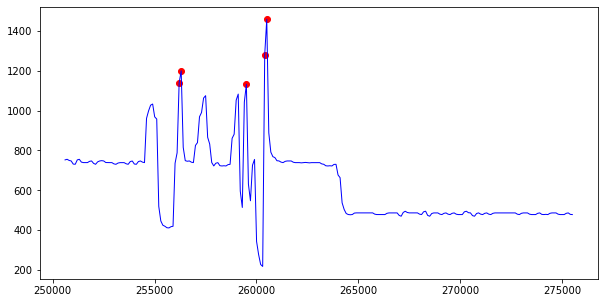

11


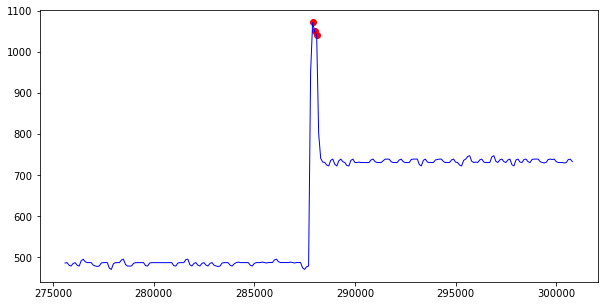

12


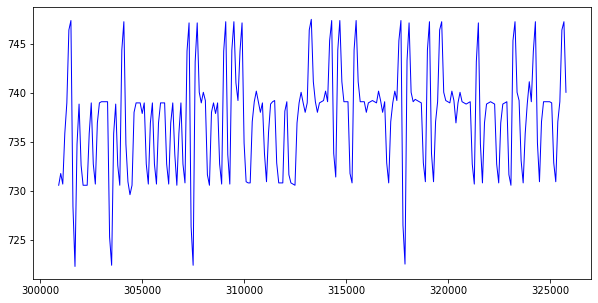

13


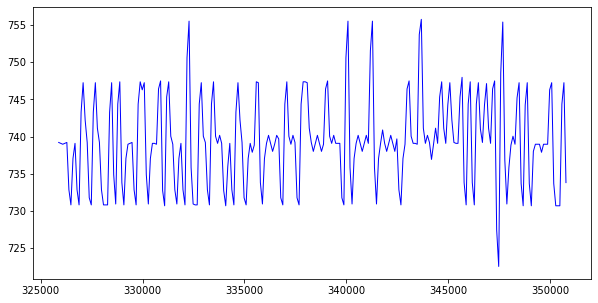

14


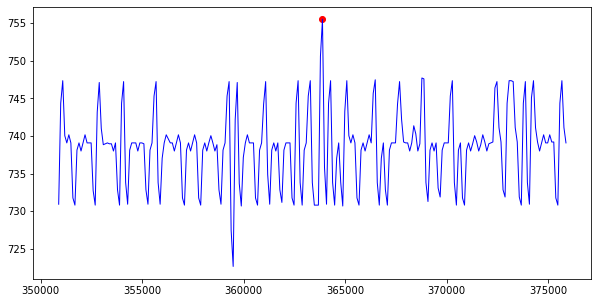

15


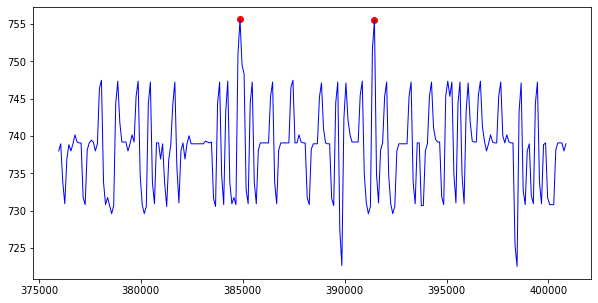

16


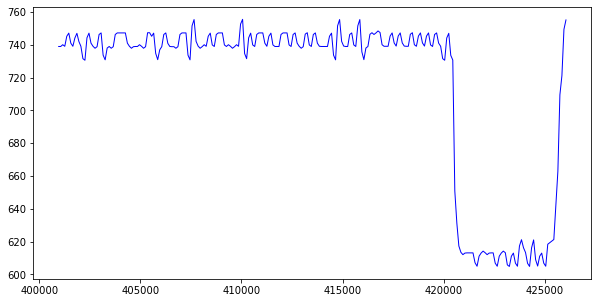

17


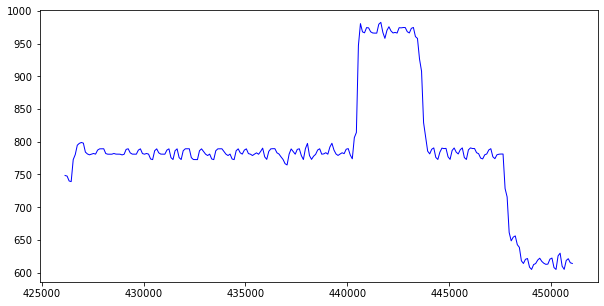

18


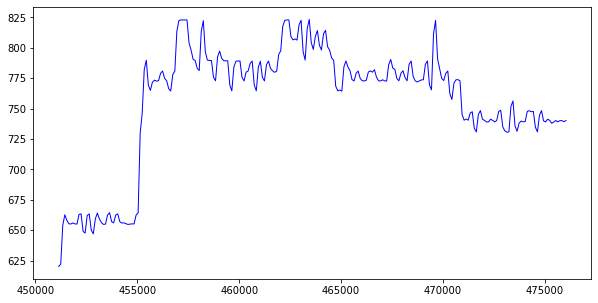

19


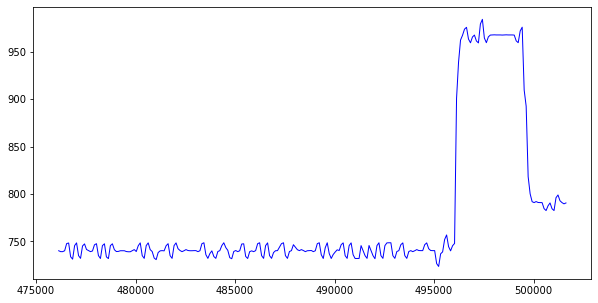

20


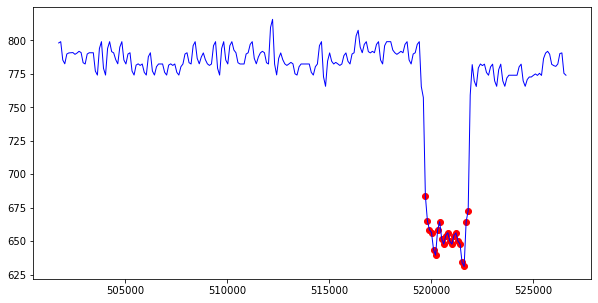

21


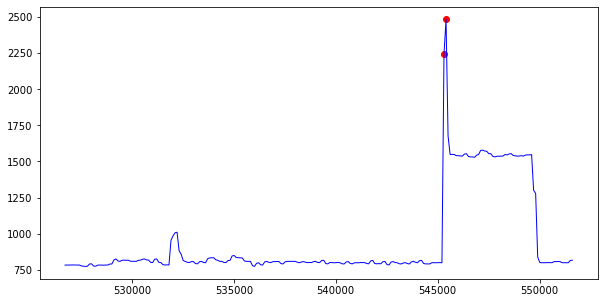

22


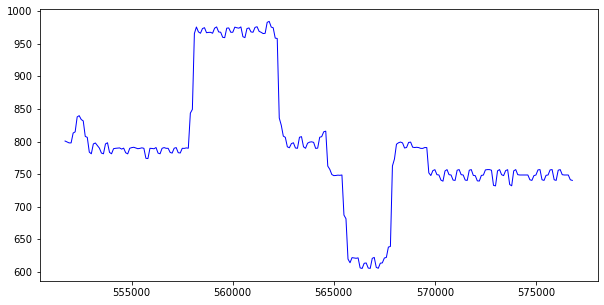

23


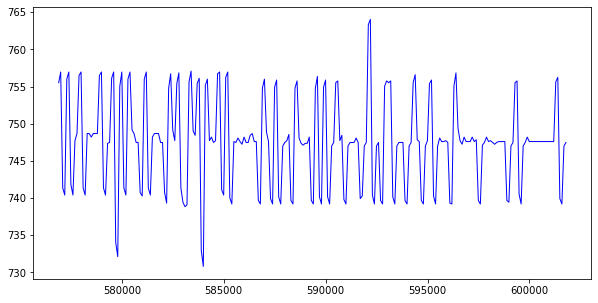

24


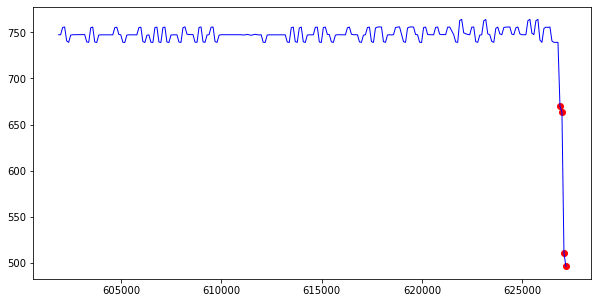

In [163]:
df = data.loc[:,('Zeitstempel_ms','Wirkleistung_gesamt')]

number_of_samples = 250
# Das Modell müssen wir nur einmal erzeugen
model = LocalOutlierFactor(n_neighbors = int(number_of_samples - number_of_samples * 0.1))

for i in range(25):
    df1 = df[i * number_of_samples:(i * number_of_samples + number_of_samples)] 
    
    # Wirkleistung umformatieren in einen Wertebereich zwischen -1 und 1
    wirkleistung = np.array(df1['Wirkleistung_gesamt']).reshape(-1,1)
    
    label = model.fit_predict(wirkleistung)
    # Erzeuge 2 leere Listen
    x = []
    y = []

    for j in range(len(label)):
        if label[j]!=1:
            x.append(df1.iloc[j, 0])
            y.append(df1.iloc[j, 1])
    print(i)
    # Plot erzeugen
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df1.Zeitstempel_ms, df1.Wirkleistung_gesamt, linewidth = 1.0, color = 'b')
    ax.scatter(x, y, color = 'r', marker = 'o')

    # Plot anzeigen
    plt.show()
